Let's download the data from INSEE.

In [12]:
import urllib.request
import os
import zipfile

url = "https://www.insee.fr/fr/statistiques/fichier/4648335/bdf2017fe_csv.zip"
filename = "bdf2017fe_csv.zip"

# Define the destination directory
dest_dir = 'already_downloaded_data'

# Create the destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Join the destination directory with the filename to create the full destination path
dest_path = os.path.join(dest_dir, filename)

# Download the file and save it to the destination path
urllib.request.urlretrieve(url, dest_path)

# Extract the contents of the zip file to the destination directory
with zipfile.ZipFile(dest_path, 'r') as zip_ref:
    zip_ref.extractall(dest_dir)



In [13]:
import pandas as pd

csv_filename = "tf106.csv"
csv_filepath = os.path.join(dest_dir, csv_filename)

df = pd.read_csv(csv_filepath, sep=";")

In [14]:
df = df.drop(df[df['DECUC'] == 'TOT'].index)

In [15]:
# filtering values with exactly 4 characters, corresponding to ECOICOP classes
df = df.loc[df['NOMENCLATURE'].str.len() == 4]

In [16]:
# renaming the "NOMENCLATURE" column to "FCOICOP"
df = df.rename(columns={'NOMENCLATURE': 'FCOICOP'})

In [17]:
# filtering out rows where the "FCOIC" value starts with "13"
df = df.loc[~df['FCOICOP'].str.startswith('13')]

In [18]:
# loading the second csv file with the "FCOICOP" column
df2 = pd.read_csv('Nomenclature_classes_to_special_aggregates.csv')

In [19]:
# merging the two dataframes on the "FCOICOP" column
merged_df = pd.merge(df, df2, on='FCOICOP')

In [20]:
# calculating the sum of "CONSO" for each unique value in "DECUC" column
sum_by_decuc = merged_df.groupby('DECUC')['CONSO'].sum()

In [21]:
# adding a new column "PROP" with the percentage of each row relative to the sum for each unique value in "DECUC" column
merged_df['PROP'] = merged_df['CONSO'] / merged_df['DECUC'].map(sum_by_decuc)

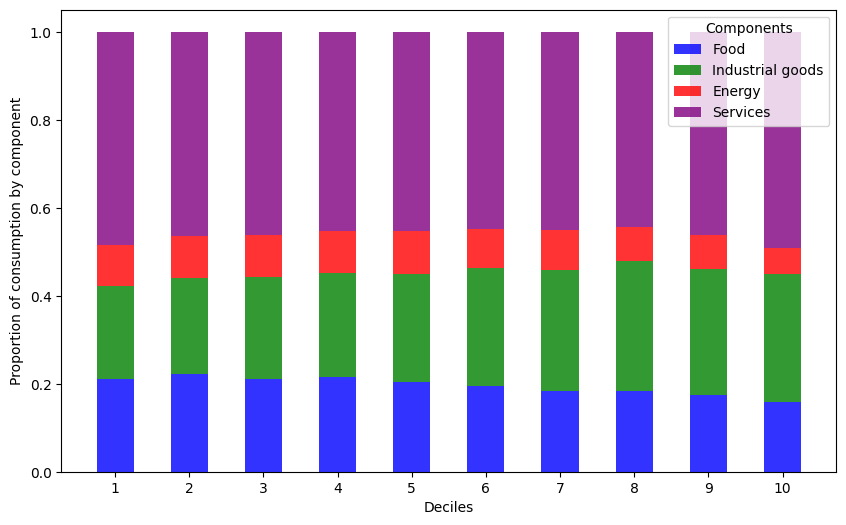

In [26]:
import matplotlib.pyplot as plt

# group the merged dataframe by "AGGREGATE" and "DECUC" and sum the values in the "PROP" column for each group
grouped_df = merged_df.groupby(['AGGREGATE', 'DECUC'])['PROP'].sum().reset_index()


# create a new column "DECUC_SORTED" with values sorted in a specific order
decuc_order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
grouped_df['DECUC_SORTED'] = pd.Categorical(grouped_df['DECUC'], categories=decuc_order, ordered=True)

# pivot the dataframe to create a table where each row represents a DECUC, and each column represents an AGGREGATE with the values in the "PROP" column
pivoted_df = grouped_df.pivot(index='DECUC_SORTED', columns='AGGREGATE', values='PROP').fillna(0)


# calculate the cumulative sum of the values in the pivoted dataframe
cumulative_df = pivoted_df.cumsum(axis=1)



# create a stacked bar chart with a bar for each DECUC and bars of colors with sizes proportional to PROP for each AGGREGATE
fig, ax = plt.subplots(figsize=(10, 6))

for i, (colname, color) in enumerate(zip(pivoted_df.columns, ['blue', 'green', 'red', 'purple'])):
    ax.bar(pivoted_df.index, pivoted_df[colname], bottom=cumulative_df.iloc[:, i-1] if i>0 else None, width=0.5, color=color, alpha=0.8, label=colname)

# change the legend labels using a dictionary
legend_labels = {'FOOD': 'Food', 'IGD': 'Industrial goods', 'SERV': 'Services', 'NRG': 'Energy'}
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels[label] if label in legend_labels else label for label in labels]
ax.legend(handles, new_labels, title="Components")

ax.set_xlabel("Deciles")
ax.set_ylabel("Proportion of consumption by component")
plt.show()


plt.show()